Reference: https://jump.dev/JuMP.jl/stable/tutorials/algorithms/tsp_lazy_constraints/

In [1]:
using JuMP
using GLPK
using Random
using Plots

In [2]:
function generate_distance_matrix(n; random_seed = 1)
    rng = Random.MersenneTwister(random_seed)
    X = 100 * rand(rng, n) # x 좌표
    Y = 100 * rand(rng, n) # y 좌표
    d = [sqrt((X[i] - X[j])^2 + (Y[i] - Y[j])^2) for i in 1:n, j in 1:n] #distance
    return X, Y, d
end

n = 20
X, Y, d = generate_distance_matrix(n)

([23.603334566204694, 34.651701419196044, 31.27069683360675, 0.790928339056074, 48.86128300795012, 21.096820215853597, 95.1916339835734, 99.99046588986135, 25.166218303197184, 98.66663668987997, 55.57510873245724, 43.71079746096251, 42.471785049513144, 77.3223048457377, 28.11902322857298, 20.947237319807076, 25.137920979222493, 2.037486871266725, 28.77015122756894, 85.9512136087661], [7.695088688120899, 64.03962459899388, 87.35441302706855, 27.85824200287785, 75.13126327861701, 64.4883353942093, 7.782644396003469, 84.81854810000327, 8.56351682044918, 55.32055454580578, 46.33502459235987, 18.582130997265377, 11.198087695816717, 97.6311881619359, 5.161462067432709, 53.80295812064833, 45.56920516275036, 27.93951106725605, 17.824610354168602, 54.89828719625274], [0.0 57.417533359853884 … 11.371156651593584 78.20102282262022; 57.417533359853884 0.0 … 46.587768505328015 52.107619408284236; … ; 11.371156651593584 46.587768505328015 … 0.0 68.1478643072081; 78.20102282262022 52.107619408284236 

In [3]:
function build_tsp_model(d, n)
    model = Model(GLPK.Optimizer)
    @variable(model, x[1:n, 1:n], Bin, Symmetric)
    @objective(model, Min, sum(d .* x) / 2)
    @constraint(model, [i in 1:n], sum(x[i, :]) == 2)
    @constraint(model, [i in 1:n], x[i, i] == 0)
    return model
end

build_tsp_model (generic function with 1 method)

In [4]:
function subtour(edges::Vector{Tuple{Int,Int}}, n)
    shortest_subtour, unvisited = collect(1:n), Set(collect(1:n))
    while !isempty(unvisited)
        this_cycle, neighbors = Int[], unvisited
        while !isempty(neighbors)
            current = pop!(neighbors)
            push!(this_cycle, current)
            if length(this_cycle) > 1
                pop!(unvisited, current)
            end
            neighbors =
                [j for (i, j) in edges if i == current && j in unvisited]
        end
        if length(this_cycle) < length(shortest_subtour)
            shortest_subtour = this_cycle
        end
    end
    return shortest_subtour
end

subtour (generic function with 1 method)

In [5]:
function selected_edges(x::Matrix{Float64}, n)
    return Tuple{Int,Int}[(i, j) for i in 1:n, j in 1:n if x[i, j] > 0.5]
end

selected_edges (generic function with 1 method)

In [6]:
subtour(x::Matrix{Float64}) = subtour(selected_edges(x, size(x, 1)), size(x, 1))
subtour(x::AbstractMatrix{VariableRef}) = subtour(value.(x))

subtour (generic function with 3 methods)

In [7]:
iterative_model = build_tsp_model(d, n)
optimize!(iterative_model)
time_iterated = solve_time(iterative_model)
cycle = subtour(iterative_model[:x])
while 1 < length(cycle) < n
    println("Found cycle of length $(length(cycle))")
    S = [(i, j) for (i, j) in Iterators.product(cycle, cycle) if i < j]
    @constraint(
        iterative_model,
        sum(iterative_model[:x][i, j] for (i, j) in S) <= length(cycle) - 1,
    )
    optimize!(iterative_model)
    global time_iterated += solve_time(iterative_model)
    global cycle = subtour(iterative_model[:x])
end

objective_value(iterative_model)

Found cycle of length 3


416.4107225079191

In [8]:
time_iterated

0.004640817642211914

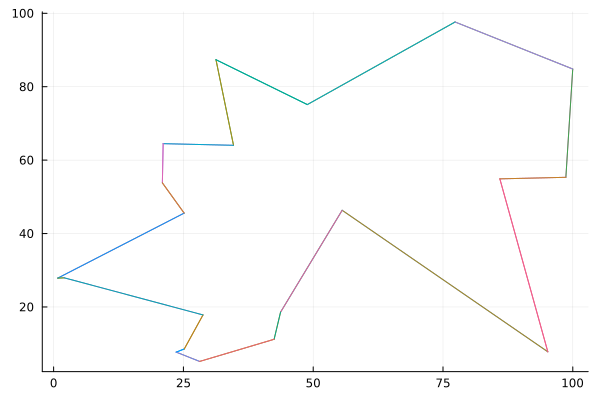

In [9]:
function plot_tour(X, Y, x)
    plot = Plots.plot()
    for (i, j) in selected_edges(x, size(x, 1))
        Plots.plot!([X[i], X[j]], [Y[i], Y[j]]; legend = false)
    end
    return plot
end

plot_tour(X, Y, value.(iterative_model[:x]))